# Tutorial for resonance fitting using `pleiades`
Tsviki Y. Hirsh and Alex Long

June 20th 2024


Tutorial to run `pleiades` using two approaches:

- **High level usage:** simple api that should work for most use cases of resonance fitting
- **Low level usage:** bare bones api - full customization


In [337]:
%pylab inline
import pandas

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


The `sammy` command must be in your path

In [338]:
# add SAMMY to PATH 
import os
os.environ['PATH'] += os.pathsep + '/sammy/sammy/build/bin'

# Grab some data from EXFOR


We will be using data from this (link)[https://www-nds.iaea.org/index-meeting-crp/CM-RF-2013/] that provides several datasets for transmission spectra that were measured at leading TOF facilities.

For the purpose of this demonstration we will be using the dataset of natural Eu measurement that were done at RPI,

- sample thickness: 4.5E-04 atoms/barn
- flight path length: 14.96 m

In [15]:
!wget --header="User-Agent: Mozilla/5.0" https://www-nds.iaea.org/exfor//servlet/X4sGetSubent?subID=14382012

--2024-06-26 06:10:57--  https://www-nds.iaea.org/exfor//servlet/X4sGetSubent?subID=14382012
Resolving www-nds.iaea.org (www-nds.iaea.org)... 104.20.50.185, 2606:4700:10::ac43:1189, 2606:4700:10::6814:32b9, ...
Connecting to www-nds.iaea.org (www-nds.iaea.org)|104.20.50.185|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/plain]
Saving to: ‘X4sGetSubent?subID=14382012.1’

X4sGetSubent?subID=     [    <=>             ]  90.67K  98.4KB/s    in 0.9s    

2024-06-26 06:10:59 (98.4 KB/s) - ‘X4sGetSubent?subID=14382012.1’ saved [92849]



In [300]:
data = pandas.read_fwf("X4sGetSubent?subID=14382012",widths=[11,11,11],skiprows=78,skipfooter=3,header=None,
                        engine="python",names=["E","T","T_err"]).set_index("E").sort_index()
data.head()

,T,T_err
E,,
0.010038,0.012402,0.001609
0.010087,0.009229,0.001445
0.010137,0.011376,0.001538
0.010186,0.011549,0.001548
0.010236,0.010950,0.001486


Text(0.5, 1.0, 'EXFOR 14382012 $^{nat}$Eu transmission')

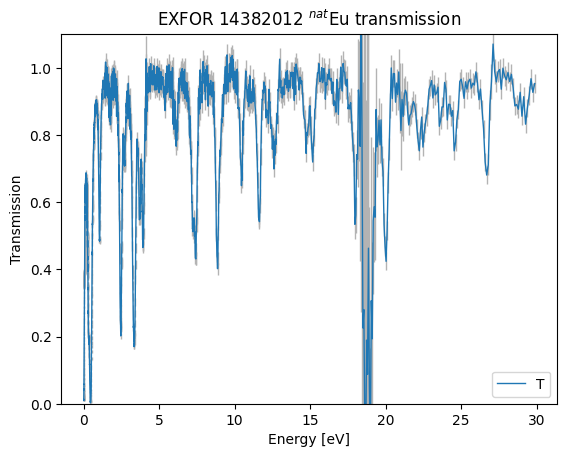

In [287]:
data.plot(y="T",yerr="T_err",ecolor="0.7",ylim=(0,1.1),lw=1)
ylabel("Transmission")
xlabel("Energy [eV]")
title("EXFOR 14382012 $^{nat}$Eu transmission")

# High level usage of `pleiades`

In [320]:
from pleiades import sammyInput,sammyUtils,sammyOutput

## Transmission data file
First let's save transmission data in the correct format

In [326]:
!mkdir -p archive/Eu_high

In [327]:
savetxt("archive/Eu_high/Eu_high.dat",data.reset_index().values,fmt="%20.10f",delimiter="")

## Grab cross sections from ENDF
Generate cross sections from ENDF, just supply the isotope name and flight path distance

In [322]:
sammyUtils.sammy_par_from_endf("Eu-151",14.96)
sammyUtils.sammy_par_from_endf("Eu-153",14.96)

## Run SAMMY
Configure fit parameters using the params dictionary, run SAMMY and plot results

In [329]:
params = {
    
# thickness and temperature
 'thickness':	    4.5e-4,	'vary_thickness':	1,
 'temperature':	    296,	'vary_temperature':	0,
      
# normalization 
'normalization': 1.,	'vary_normalization':	         1, 
'constant_bg': 0.0001,	'vary_constant_bg':	             1,   
# 'one_over_v_bg': 0.0001,	'vary_one_over_v_bg':	         0, 
# 'sqrt_energy_bg': 0.0001	,'vary_sqrt_energy_bg':	         0,
# 'exponential_bg': 0.00	,'vary_exponential_bg':	         0,
# 'exp_decay_bg': 0.00,	'vary_exp_decay_bg':	         0, 

# broadening 
 # 'flight_path_spread':	  0.001075,	'vary_flight_path_spread':	         1,
 # 'deltag_fwhm':		    30.5834,	'vary_deltag_fwhm':		         1,
 # 'deltae_us':		  0.001006,	'vary_deltae_us':		         1,
 # 'flight_path_spread':	  0.01,	'vary_flight_path_spread':	 1,
 # 'deltag_fwhm':		    0.1,	'vary_deltag_fwhm':		         1,
 # 'deltae_us':		  0,	'vary_deltae_us':		         0,

# misc. tzero    
 # 't0':	   1.1875,		'vary_t0':	         1,
 # 'L0':	  0.988967,		'vary_L0':	         1,

# misc. delta-L
 # 'delta_L1':	 -0.004762,	'delta_L1_err':	        '',	'vary_delta_L1':	         1,
 # 'delta_L0':	  0.092731,	'delta_L0_err':	        '',	'vary_delta_L0':	         1,

# # misc. delta-E
 # 'DE':		   0.20044,	'DE_err':	        '',	'vary_DE':	         1,
 # 'D0':		    13.618,	'D0_err':	        '',	'vary_D0':	         1,
 # 'DlnE':	   -5.0151,	'DlnE_err':	        '',	'vary_DlnE':	         1,
}

In [334]:
output = sammyUtils.run_sammy_fit(archivename="Eu_high",
                                  abundances={"Eu151":0.472,"Eu153":0.528},
                                  params=bg,
                                  emin=0.1,
                                  emax =30,
                                  res_emin= -500,
                                  res_emax=1500,
                                  flight_path_length=14.96,
                                  fudge_factor=100,
                                  )

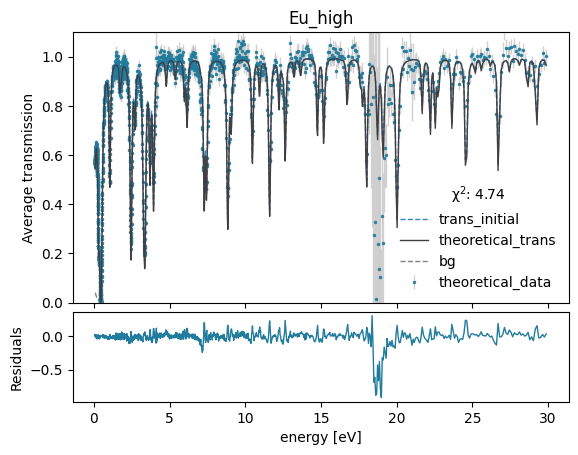

In [336]:
sammyUtils.plot_transmission("Eu_high",output);
ylim(0,1.1); legend(title=f"χ$^2$: {output['reduced_chi2']:.2f}",frameon=False);

# Low level usage of `pleiades`

Running `SAMMY` requires creating 3 files:
- `.dat` file - This is the transmission data saved in a special `twenty` column format
- `.inp` file: Contains basic info and fit commands.
- `.dat` file: Contains the particle pair information, spin groups and resonance tables for the reaction. We will use `pleiades.ParFile` to create one

## Create `.dat` file

Create a directory and save the data using the right format

In [288]:
!mkdir archive/Eu_nat -p

In [289]:
savetxt("archive/Eu_nat/Eu_nat.dat",data.reset_index().values,fmt="%20.10f",delimiter="")

## Create `.inp` file

We will use `pleiades.sammyInput.InputFile` to create an input file.

The InputFile class uses a config file to collect the necassary data for the input file, we are going to write a minimal config file for that. This is pretty general config file, usually you only need to change element name and the atomic weight

In [263]:
%%writefile archive/Eu_nat/Eu_nat.ini
[Card1]
TITLE = Eu_nat transmission from RPI

[Card2]
ELMNT = Eu_nat
AW = 151.96
EMIN = 1
EMAX = 15
ITMAX = 15

[Card3]
commands = CHI_SQUARED,TWENTY,SOLVE_BAYES,QUANTUM_NUMBERS,REICH_MOORE_FORMAT,GENERATE ODF FILE AUTOMATICALLY,USE I4 FORMAT TO READ SPIN GROUP NUMBER

[Card5]
TEMP = 296.
DIST = 14.96

[Card7]
CRFN = 1.0
THICK = 4.5E-04

[Card8]
CROSS = TRANSMISSION 

Overwriting archive/Eu_nat/Eu_nat.ini


In [264]:
from pleiades import sammyInput

inp = sammyInput.InputFile("archive/Eu_nat/Eu_nat.ini",auto_update=False)

# process commands and write to file
inp.process(auto_update=False).write("archive/Eu_nat/Eu_nat.inp")

In [265]:
!cat archive/Eu_nat/Eu_nat.inp

Eu_nat transmission from RPI                                                    
Eu_nat        151.96       1.0      15.010001   1550  0 9 5         0 2 2     0
CHI SQUARED IS WANTEd
USE TWENTY SIGNIFICAnt digits
SOLVE BAYES EQUATIONs
QUANTUM NUMBERS ARE in parameter file
REICH_MOORE_FORMAT
GENERATE ODF FILE AUTOMATICALLY
USE I4 FORMAT TO READ SPIN GROUP NUMBER

     296.0     14.96       0.0       0.0       0.0       0.0       0.0
       1.0   0.00045       0.0       0.0       0.0
TRANSMISSION                                                                    



## Generate `.par` file
pleiades requires creating a separate `.par` file for each isotope and then these can be combined into a single `.par` file for the isotopic compounds.

Creating a par file for each isotope is easy using the `sammyUtils.sammy_par_from_endf` method, just supply the isotope name and flight path distance

pleiades automatically runs SAMMY in the background to create that par files, the par files are saved at `archive/Eu151/results/Eu151.par` and `archive/Eu153/results/Eu153.par`. They contain the resonance tables extracted from ENDF8

In [266]:
from pleiades import sammyUtils
sammyUtils.sammy_par_from_endf("Eu-151",14.96)
sammyUtils.sammy_par_from_endf("Eu-153",14.96)

In [267]:
!head -n 20 archive/Eu151/results/Eu151.par

PARTICLE PAIR DEFINITIONS
Name=PPair1       Particle a=neutron       Particle b=Other   
     Za= 0        Zb=63         Pent=1     Shift=0
     Sa=  0.5     Sb=   2.5     Ma=   1.008664915780000     Mb= 150.916445000000010
 
SPIN GROUP INFORMATION
  1      1    0  2.0 1.0000000                                                  
    1    PPair1    0         2            7.90000000 7.34863269                 
  2      1    0  3.0 1.0000000                                                  
    1    PPair1    0         3            7.90000000 7.34863269                 
 
RESONANCE PARAMETERS
1.815000000 91.0000100 4.080000-2                                 1             
3.368000000 93.0000000 2.19600000                                 1             
3.710000000 93.0000000 0.94800010                                 1             
4.790000000 91.0000100 0.18000000                                 1             
7.050000000 91.0000100 6.360000-2                                 1             

Now use `sammyParFile.ParFile` to read the isotopes par files. Here I can assign weights of each isotope, that can be enrichment level or natural abundance like in this case. Use the `.read()` method to read the file content.

Creating a compound is easy, just add the ParFile objects.

Then write the par file in the archive/Eu_nat directory

In [268]:
from pleiades import sammyParFile

eu151 = sammyParFile.ParFile("archive/Eu151/results/Eu151.par",weight=0.478,emin=1).read()
eu153 = sammyParFile.ParFile("archive/Eu153/results/Eu153.par",weight=0.522,emin=1).read()

eunat = eu151 + eu153

The `eunat.data` object contains the data about parameters that you can decide to fix/vary, e.g. the normalization key has all the background parameters that you can decide to vary.

You can also use the `update` methods to update the data

In [269]:
eunat.data.keys()

dict_keys(['info', 'particle_pairs', 'spin_group', 'channel_radii', 'resonance_params', 'isotopic_masses', 'normalization', 'broadening', 'resolution', 'misc'])

In [270]:
eunat.update.broadening(thickness=0.00045,vary_thickness=0)
eunat.update.normalization(vary_normalization=1,constant_bg=0.01,vary_constant_bg=1)
eunat.data["info"]["fudge_factor"] = 10

In [271]:
eunat.data["broadening"]

{'temperature': '296.',
 'thickness': 0.00045,
 'flight_path_spread': '',
 'deltag_fwhm': '',
 'deltae_us': '',
 'vary_temperature': 0,
 'vary_thickness': 0,
 'vary_flight_path_spread': 0,
 'vary_deltag_fwhm': 0,
 'vary_deltae_us': 0}

Now write the par file

In [272]:
eunat.write("archive/Eu_nat/Eu_nat.par")

The par file now contains information about the two isotopes

In [273]:
!head -n 25 archive/Eu_nat/Eu_nat.par

PARTICLE PAIR DEFINITIONS
Name=Eu151        Particle a=neutron       Particle b=Other   
     Za= 0        Zb=63         Pent=1     Shift=0
     Sa=  0.5     Sb=   2.5     Ma=   1.008664915780000     Mb= 150.916445000000010
Name=Eu153        Particle a=neutron       Particle b=Other   
     Za= 0        Zb=63         Pent=1     Shift=0
     Sa=  0.5     Sb=   2.5     Ma=   1.008664915780000     Mb= 152.921671000000003
 
SPIN GROUP INFORMATION
  1      1    0  2.00.4780000                                                   
    1  Eu151       0         2            7.90000000 7.34863269                 
  2      1    0  3.00.4780000                                                   
    1  Eu151       0         3            7.90000000 7.34863269                 
  3      1    0  2.00.5220000                                                   
    1  Eu153       0         2            8.20000000 7.37750905                 
  4      1    0  3.00.5220000                                      

## Run SAMMY
We are using `pleiades.sammyRunner` to run sammy. If no error is printed, the output files should be located at the `archive/Eu_nat/results` directory. The important fils are the `archive/Eu_nat/results/Eu_nat.lst` and `archive/Eu_nat/results/Eu_nat.lpt` files

In [274]:
from pleiades import sammyRunner
sammyRunner.run(archivename="Eu_nat")

The $\chi^2$ and all parameter values and uncertainties are all in the lpt file

In [275]:
!tail -n 20 archive/Eu_nat/results/Eu_nat.lpt

   Number      at Emin       at Emax        at Emin       at Emax
      1       2.611366E-02  0.101138      4.348209E-02  0.168405    
      2       2.594188E-02  0.100472      4.319606E-02  0.167298    
  
      E(keV)    Dopp_FWHM(keV)
      0.001000         0.0435
      0.008000         0.1230
      0.015000         0.1684
  

 Energy range of data is from 1.00000E+00 to 1.50000E+01 eV.
 Number of experimental data points =    1044


 ** 11 resonances have fewer than 9 points across width
 Number of points in auxiliary grid =    1273

 CUSTOMARY CHI SQUARED =   2101.79    
 CUSTOMARY CHI SQUARED DIVIDED BY NDAT =   2.01321    
 Normal finish to SAMMY


## Plot results
Read the lst file and plot results

<Axes: xlabel='energy'>

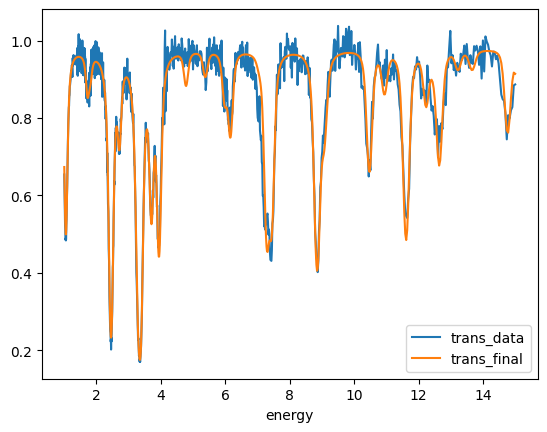

In [276]:
results = pandas.read_csv("archive/Eu_nat/results/Eu_nat.lst",
                              delim_whitespace=True,header=None,
                names=["energy","xs_data",
                       "xs_data_err","xs_initial",
                       "xs_final","trans_data",
                       "trans_data_err","trans_initial",
                       "trans_final","trans_err",
                       "trans_err2","initial_energy","final_energy"]).dropna(axis=1,how="all").dropna()
results.plot(x="energy",y=["trans_data","trans_final"])